# 采用5折交叉验证，分别用log似然损失和正确率，对Logistic回归模型的正则超参数调优。（各50分） 

In [5]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#input data
train = pd.read_csv("FE_pima-indians-diabetes.csv")
train.head()

,pregnants,Plasma_glucose_concentration,blood_pressure,Triceps_skin_fold_thickness,serum_insulin,BMI,Diabetes_pedigree_function,Age,Target
0,0.639947,0.866045,-0.031990,0.670643,-0.181541,0.166619,0.468492,1.425995,1
1,-0.844885,-1.205066,-0.528319,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672,0
2,1.233880,2.016662,-0.693761,-0.012301,-0.181541,-1.332500,0.604397,-0.105584,1
3,-0.844885,-1.073567,-0.528319,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549,0
4,-1.141852,0.504422,-2.679076,0.670643,0.316566,1.549303,5.484909,-0.020496,1


In [4]:
train.shape

(768, 9)

In [8]:
y_train = train['Target']   
X_train = train.drop(["Target"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

In [10]:
#sklearn的学习器大多支持稀疏数据输入，模型训练会快很多
#查看一个学习器是否支持稀疏数据，可以看fit函数是否支持: X: {array-like, sparse matrix}.

from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

## 默认参数的Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [21]:
# 交叉验证用于评估模型性能和进行参数调优（模型选择）
#分类任务中交叉验证缺省是采用StratifiedKFold
#数据集比较大，采用3折交叉验证
from sklearn.model_selection import cross_val_score
loss = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_log_loss') #accuracy
#loss = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy') #accuracy正确率
#%timeit loss_sparse = cross_val_score(lr, X_train_sparse, y_train, cv=3, scoring='neg_log_loss')
print ('logloss of each fold is: ',-loss)
print ('cv logloss is:', -(loss.mean()))


logloss of each fold is:  [ 0.48797856  0.53011593  0.4562292   0.422546    0.48392885]
cv logloss is: 0.476159709444


### logistic回归的需要调整超参数有：C（正则系数，一般在log域（取log后的值）均匀设置候选参数）和正则函数penalty（L2/L1） 目标函数为：J = C* sum(logloss(f(xi), yi)) + penalty 

在sklearn框架下，不同学习器的参数调整步骤相同：
1.设置参数搜索范围
2.生成学习器实例（参数设置）
3.生成GridSearchCV的实例（参数设置）
4.调用GridSearchCV的fit方法


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

### log似然损失，5折交叉验证 进行参数调优

In [24]:
penaltys = ['l1','l2']
Cs = [ 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression(solver='liblinear')
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=5, scoring='neg_log_loss',n_jobs = 4,)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [25]:
print("最小log损失：", -grid.best_score_)
print("最佳超参数：", grid.best_params_) 

0.476028846231
{'C': 1, 'penalty': 'l1'}


### 准确率，5折交叉验证 进行参数调优

In [28]:
lr_penalty_accuracy= LogisticRegression(solver='liblinear')
grid_accuracy= GridSearchCV(lr_penalty_accuracy, tuned_parameters,cv=5, scoring='accuracy',n_jobs = 4,)
grid_accuracy.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [29]:
print("最佳准确率：", grid_accuracy.best_score_)
print("最佳超参数：", grid_accuracy.best_params_) 

最佳准确率： 0.774739583333
最佳超参数： {'C': 0.1, 'penalty': 'l2'}


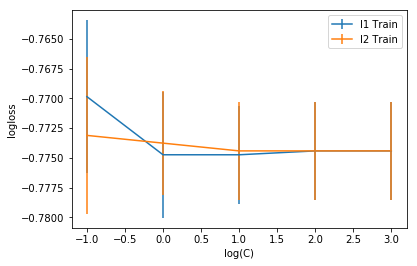

In [30]:
# plot CV误差曲线
train_means = grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]

# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)

train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)


x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    plt.errorbar(x_axis, -train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys[i] +' Train')
    
plt.legend()
plt.xlabel( 'log(C)' )                                                                                                      
plt.ylabel( 'logloss' )
plt.savefig('LogisticGridSearchCV_C.png' )

plt.show()

从图中可以看到，在 log(C)取0的时候（C=1） 并且蓝色的线即 l1 正则时log损失最小

## 保存模型，用于后续测试

In [32]:
import pickle as cPickle

cPickle.dump(grid.best_estimator_, open("logloss_l1.pkl", 'wb'))
cPickle.dump(grid_accuracy.best_estimator_, open("accuracy_l2.pkl", 'wb'))